In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from os.path import join
from collections import defaultdict
import matplotlib.pylab as plt
from torch.utils.data import DataLoader, Dataset

from circuit_toolkit.GAN_utils import upconvGAN
from circuit_toolkit.CNN_scorers import TorchScorer, load_featnet
from circuit_toolkit.layer_hook_utils import featureFetcher, featureFetcher_module
from circuit_toolkit.layer_hook_utils import get_module_names, register_hook_by_module_names, layername_dict
from circuit_toolkit.Optimizers import CholeskyCMAES
from circuit_toolkit.dataset_utils import create_imagenet_valid_dataset
from circuit_toolkit.plot_utils import save_imgrid, saveallforms, show_imgrid
# import data loader and dataset

dataroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/DNN_neural_regress"

In [11]:
G = upconvGAN("fc6").cuda()
G.requires_grad_(False)
# scorer = TorchScorer("resnet50")
# module_names, module_types, module_spec = get_module_names(scorer.model, input_size=(3, 227, 227), device="cuda");

upconvGAN(
  (G): Sequential(
    (defc7): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc7): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc6): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc6): LeakyReLU(negative_slope=0.3, inplace=True)
    (defc5): Linear(in_features=4096, out_features=4096, bias=True)
    (relu_defc5): LeakyReLU(negative_slope=0.3, inplace=True)
    (reshape): View()
    (deconv5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv5): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv5_1): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv5_1): LeakyReLU(negative_slope=0.3, inplace=True)
    (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_deconv4): LeakyReLU(negative_slope=0.3, inplace=True)
    (conv4_1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [12]:
# Target neuron network
scorer = TorchScorer("resnet50")
scorer.select_unit(("resnet50", ".layer3.Bottleneck5", 5, 6, 6), allow_grad=True)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


use the default resnet50 weights


In [13]:
regresslayer = ".layer3.Bottleneck5"
featnet, net = load_featnet("resnet50_linf8")
featFetcher = featureFetcher(featnet, input_size=(3, 227, 227), device="cuda", print_module=False)
featFetcher.record(regresslayer,)

In [14]:
#%% Evolution experiment

feattsr_all = []
resp_all = []
optimizer = CholeskyCMAES(4096, population_size=None, init_sigma=3.0)
z_arr = np.zeros((1, 4096))  # optimizer.init_x
pbar = tqdm(range(100))
for i in pbar:
    imgs = G.visualize(torch.tensor(z_arr).float().cuda())
    resp = scorer.score(imgs, )
    z_arr_new = optimizer.step_simple(resp, z_arr)
    z_arr = z_arr_new
    with torch.no_grad():
        featnet(scorer.preprocess(imgs, input_scale=1.0))

    del imgs
    # print(f"{i}: {resp.mean():.2f}+-{resp.std():.2f}")
    pbar.set_description(f"{i}: {resp.mean():.2f}+-{resp.std():.2f}")
    feattsr = featFetcher[regresslayer]
    feattsr_all.append(feattsr.cpu().numpy())
    resp_all.append(resp)

resp_all = np.concatenate(resp_all, axis=0)
feattsr_all = np.concatenate(feattsr_all, axis=0)

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


  0%|          | 0/100 [00:00<?, ?it/s]

sigma: 2.90
sigma: 2.83
sigma: 2.76
sigma: 2.71
sigma: 2.66
sigma: 2.62
sigma: 2.59
sigma: 2.56
sigma: 2.53
sigma: 2.51
sigma: 2.49
A, Ainv update! Time cost: 0.22 s
sigma: 2.47
sigma: 2.45
sigma: 2.44
sigma: 2.42
sigma: 2.41
sigma: 2.40
sigma: 2.39
sigma: 2.38
sigma: 2.37
sigma: 2.36
sigma: 2.35
A, Ainv update! Time cost: 0.22 s
sigma: 2.35
sigma: 2.34
sigma: 2.34
sigma: 2.33
sigma: 2.33
sigma: 2.32
sigma: 2.32
sigma: 2.32
sigma: 2.32
sigma: 2.31
sigma: 2.31
A, Ainv update! Time cost: 0.22 s
sigma: 2.31
sigma: 2.31
sigma: 2.31
sigma: 2.31
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
A, Ainv update! Time cost: 0.22 s
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
A, Ainv update! Time cost: 0.23 s
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.30
sigma: 2.31
sigma: 2.31
sigma: 2.31
A, Ainv update! Time cost: 0.22 s
sigm

### Regression

In [16]:
#%% Linear Modelling imports
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import johnson_lindenstrauss_min_dim, \
            SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import LogisticRegression, LinearRegression, \
    Ridge, Lasso, PoissonRegressor, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr

from neural_regress.regress_lib import sweep_regressors, compare_activation_prediction, normalizer, denormalizer
denormalizer = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225])
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
resizer = Resize(227, )

Record feature and their reduced forms 

In [18]:
#%% Prepare image features and feature tfms for modelling
featmat = feattsr_all.reshape(feattsr_all.shape[0], -1)  # B x (C*H*W)
featmat_avg = feattsr_all.mean(axis=(2, 3))  # B x C
featmat_rf = feattsr_all[:, :, 6, 6]  # B x n_components
srp = SparseRandomProjection().fit(featmat)
srp_featmat = srp.transform(featmat)  # B x n_components
pca = PCA(n_components=500)
pca_featmat = pca.fit_transform(featmat)  # B x n_components

Xdict = {"srp": srp_featmat, "pca": pca_featmat,
         "sp_avg": featmat_avg, "sp_rf": featmat_rf}
Xfeat_transformer = {'pca': lambda tsr: pca.transform(tsr.reshape(tsr.shape[0], -1)),
                     "srp": lambda tsr: srp.transform(tsr.reshape(tsr.shape[0], -1)),
                     "sp_rf": lambda tsr: tsr[:, :, 6, 6],
                     "sp_avg": lambda tsr: tsr.mean(axis=(2, 3))}

In [22]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
poissreg = PoissonRegressor(alpha=1.0, max_iter=500)
kr_rbf = KernelRidge(alpha=1.0, kernel="rbf", gamma=None, )
regressors = [ridge, lasso, poissreg, kr_rbf, ]
regressor_names = ["Ridge", "Lasso", "Poisson", "KernelRBF"]
y_all = resp_all

In [20]:
result_df, fit_models = sweep_regressors(Xdict, y_all, regressors, regressor_names, )
result_df.to_csv(join(dataroot, "insilico_results\\sweep_regressors.csv"))

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.61228e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.32475e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/si

KeyboardInterrupt: 

In [23]:
result_df, fit_models = sweep_regressors(Xdict, y_all, [ridge, lasso, kr_rbf], ["Ridge", "Lasso", "KernelRBF"],)
result_df.to_csv(join(dataroot, "insilico_results\\sweep_regressors_sub.csv"))

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.01645e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.29872e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/si

                      alpha  train_score  test_score  n_feat
srp    Ridge      1000.0000     0.963407    0.901222  7100.0
       Lasso         0.0100     0.896358    0.887767  7100.0
       KernelRBF     0.1000     0.989951    0.903013  7100.0
pca    Ridge      1000.0000     0.919767    0.897215   500.0
       Lasso         0.0100     0.900906    0.897660   500.0
       KernelRBF     0.0001     1.000000    0.558083   500.0
sp_avg Ridge         0.1000     0.912227    0.879255  1024.0
       Lasso         0.0001     0.884911    0.877954  1024.0
       KernelRBF     0.0010     0.893275    0.880459  1024.0
sp_rf  Ridge        10.0000     0.934870    0.919252  1024.0
       Lasso         0.0010     0.909912    0.908182  1024.0
       KernelRBF     0.0100     0.944263    0.920772  1024.0


In [24]:
"""Predict Scores for Evolution images"""

model_list = [('pca', "Ridge"), ('srp', "Ridge"), ('sp_avg', "Ridge"),
              ('sp_rf', "Ridge"), ('sp_rf', "KernelRBF")]

pred_scores_evol = defaultdict(list)
for k in model_list:
    featmat_tfm = Xdict[k[0]] #Xfeat_transformer[k[0]](feattsr)
    pred_score = fit_models[k].predict(featmat_tfm)
    pred_scores_evol[k] = pred_score

('pca', 'Ridge') spearman: 0.929 P=0.0e+00 pearson: 0.947 P=0.0e+00 R2=0.897


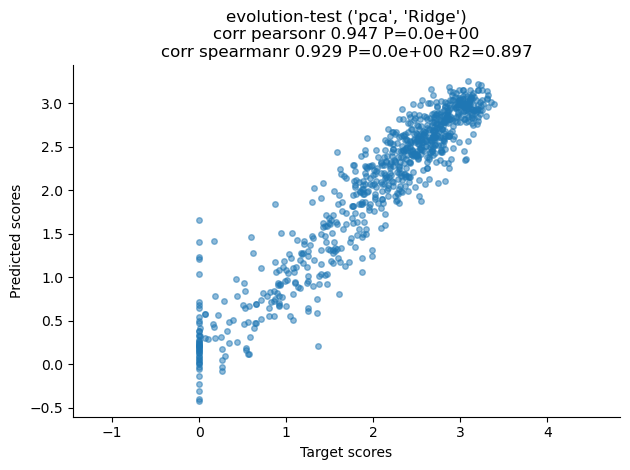

('srp', 'Ridge') spearman: 0.936 P=0.0e+00 pearson: 0.949 P=0.0e+00 R2=0.901


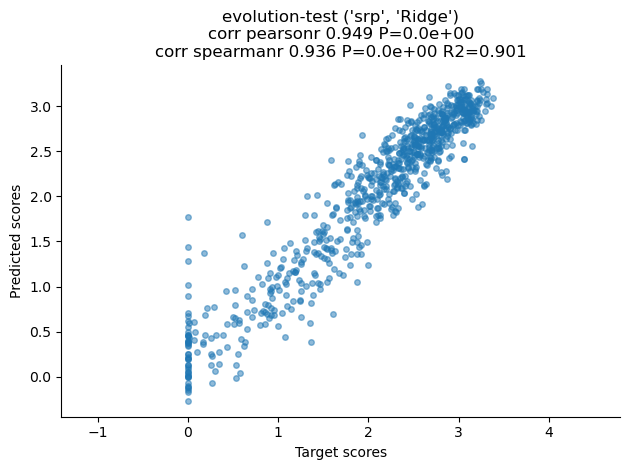

('sp_avg', 'Ridge') spearman: 0.923 P=0.0e+00 pearson: 0.938 P=0.0e+00 R2=0.879


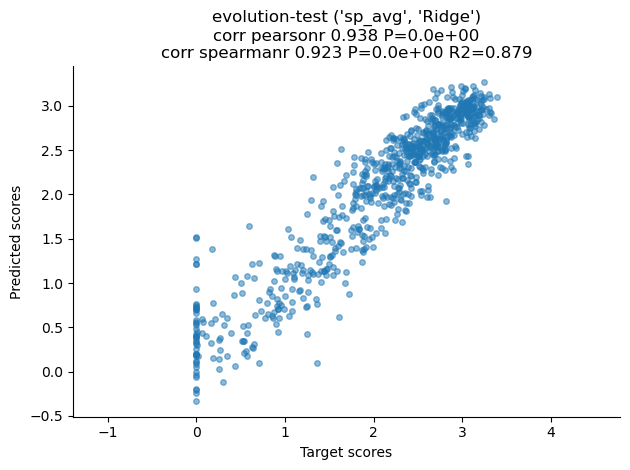

('sp_rf', 'Ridge') spearman: 0.951 P=0.0e+00 pearson: 0.959 P=0.0e+00 R2=0.920


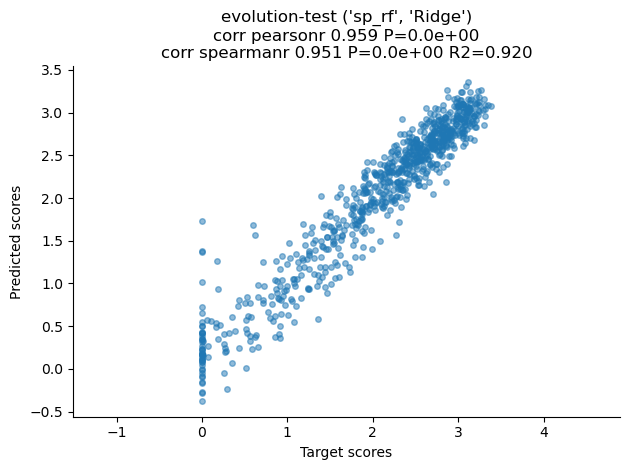

('sp_rf', 'KernelRBF') spearman: 0.951 P=0.0e+00 pearson: 0.960 P=0.0e+00 R2=0.921


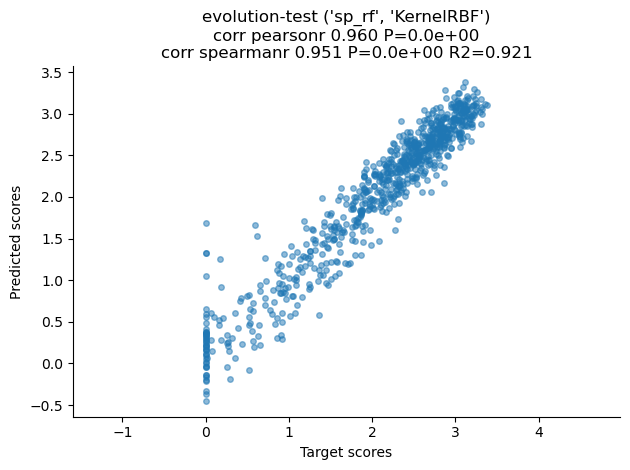

('pca', 'Ridge') spearman: 0.942 P=0.0e+00 pearson: 0.959 P=0.0e+00 R2=0.920


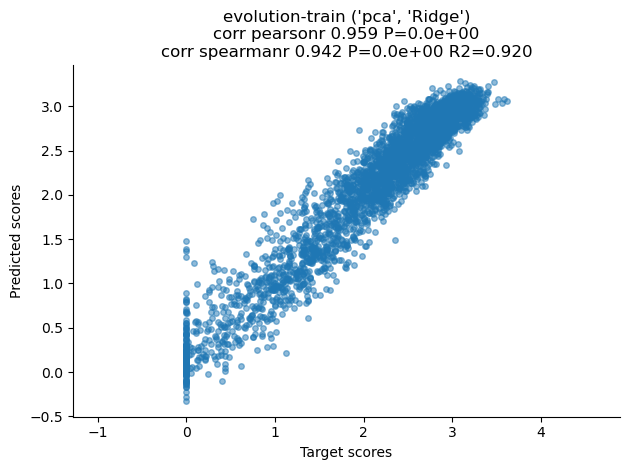

('srp', 'Ridge') spearman: 0.971 P=0.0e+00 pearson: 0.982 P=0.0e+00 R2=0.963


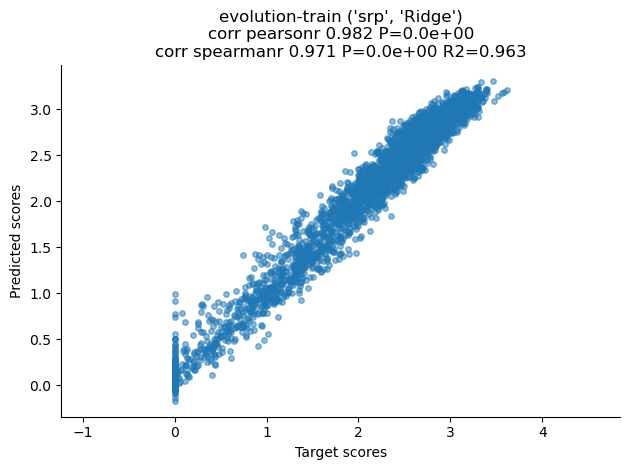

('sp_avg', 'Ridge') spearman: 0.937 P=0.0e+00 pearson: 0.955 P=0.0e+00 R2=0.912


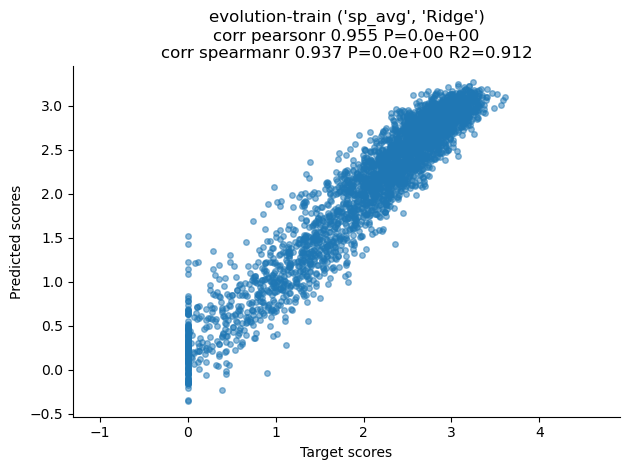

('sp_rf', 'Ridge') spearman: 0.950 P=0.0e+00 pearson: 0.967 P=0.0e+00 R2=0.935


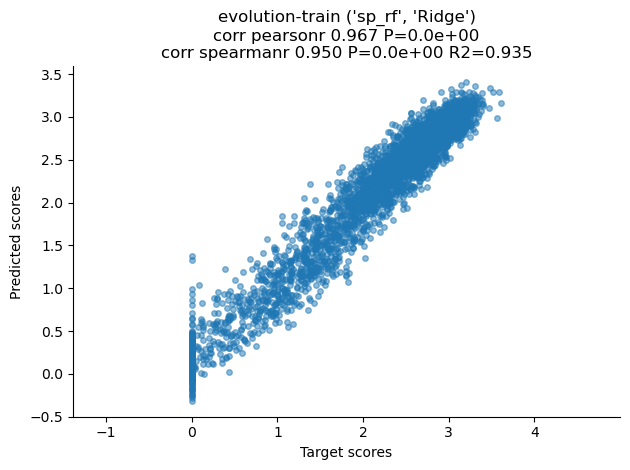

('sp_rf', 'KernelRBF') spearman: 0.956 P=0.0e+00 pearson: 0.972 P=0.0e+00 R2=0.944


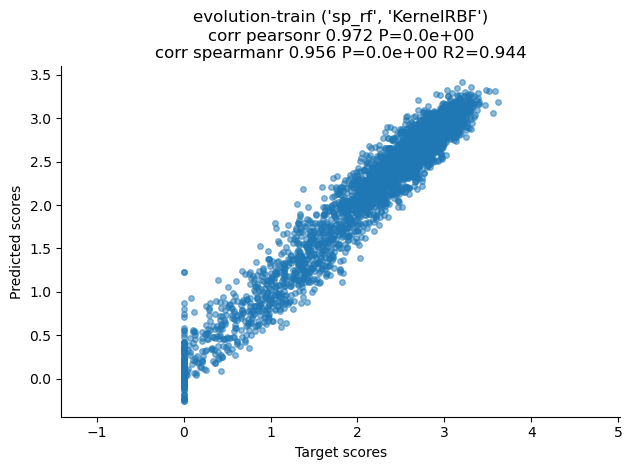

spearman   pearson  ...          dataset n_sample
pca    Ridge      0.941846  0.959079  ...  evolution-train     3168
srp    Ridge      0.970909  0.981833  ...  evolution-train     3168
sp_avg Ridge      0.936729  0.955196  ...  evolution-train     3168
sp_rf  Ridge      0.950252  0.966979  ...  evolution-train     3168
       KernelRBF   0.95553  0.971813  ...  evolution-train     3168

[5 rows x 7 columns]

In [25]:
idx_train, idx_test = train_test_split(
        range(len(y_all)), test_size=0.2, random_state=42, shuffle=True
    )
target_scores_evol_test = resp_all[idx_test]
target_scores_evol_train = resp_all[idx_train]
pred_scores_evol_test = {k: v[idx_test] for k, v in pred_scores_evol.items()}
pred_scores_evol_train = {k: v[idx_train] for k, v in pred_scores_evol.items()}
compare_activation_prediction(target_scores_evol_test, pred_scores_evol_test,
                            exptitle="evolution-test")
compare_activation_prediction(target_scores_evol_train, pred_scores_evol_train,
                            exptitle="evolution-train")

### Record activation from ImageNet and test generalization

In [ ]:
dataset = create_imagenet_valid_dataset(imgpix=227, normalize=True, rootdir="/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/imagenet-valid/")

In [ ]:
#%% Get scores from ImageNet validation set
data_loader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=0)

target_scores_natval = []
for i, (imgs, _) in tqdm(enumerate(data_loader)):
    imgs = imgs.cuda()
    with torch.no_grad():
        score_batch = scorer.score(denormalizer(imgs))
    target_scores_natval.append(score_batch)

target_scores_natval = np.concatenate(target_scores_natval, axis=0)

0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1487abd75f30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1487abd75f30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x1487abd75f30>
self._shutdown_workers()

Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/n/home12/binxu

In [32]:
""" Predicting ImageNet validation set. """
data_loader = DataLoader(dataset, batch_size=512,
                         shuffle=False, num_workers=8)

model_list = [('pca', "Ridge"), ('srp', "Ridge"), ('sp_avg', "Ridge"),
              ('sp_rf', "Ridge"), ('sp_rf', "KernelRBF")]
target_scores_natval = []
pred_scores_natval = defaultdict(list)
for i, (imgs, _) in tqdm(enumerate(data_loader)):
    imgs = imgs.cuda()
    with torch.no_grad():
        score_batch = scorer.score(denormalizer(imgs))
        # score_batch = scorer.score(imgs, skip_preprocess=True)

    target_scores_natval.append(score_batch)
    with torch.no_grad():
        featnet(imgs)
        feattsr = featFetcher[regresslayer]
        feattsr = feattsr.cpu().numpy()

    for k in model_list:
        featmat_tfm = Xfeat_transformer[k[0]](feattsr)
        pred_score = fit_models[k].predict(featmat_tfm)
        pred_scores_natval[k].append(pred_score)


target_scores_natval = np.concatenate(target_scores_natval, axis=0)
for k in pred_scores_natval:
    pred_scores_natval[k] = np.concatenate(pred_scores_natval[k], axis=0)

0it [00:00, ?it/s]

('pca', 'Ridge') spearman: 0.054 P=1.5e-33 pearson: 0.045 P=2.5e-24 R2=-1.426


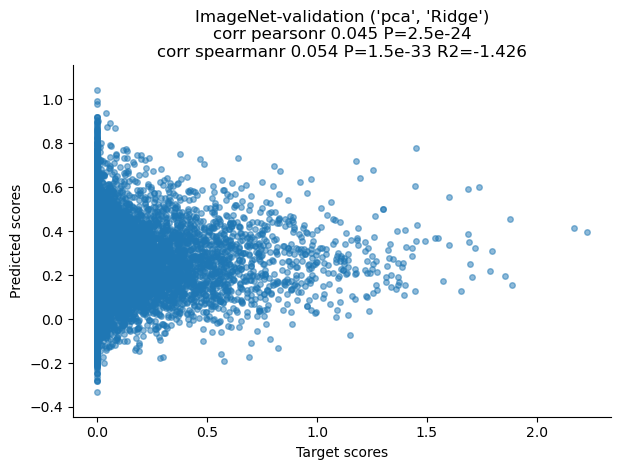

('srp', 'Ridge') spearman: 0.046 P=1.3e-24 pearson: 0.041 P=1.9e-20 R2=-2.894


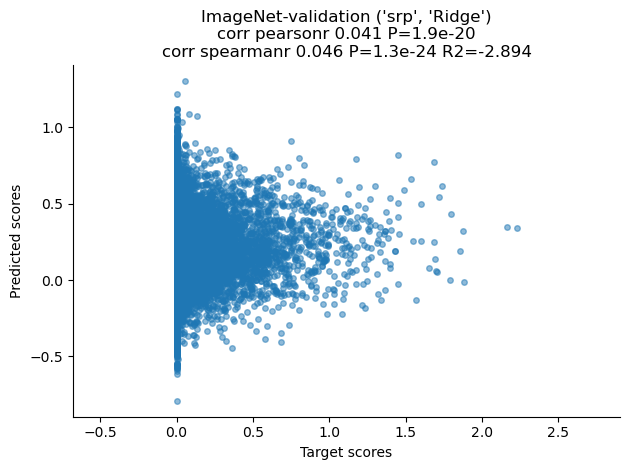

('sp_avg', 'Ridge') spearman: 0.017 P=1.5e-04 pearson: 0.023 P=4.3e-07 R2=-24.000


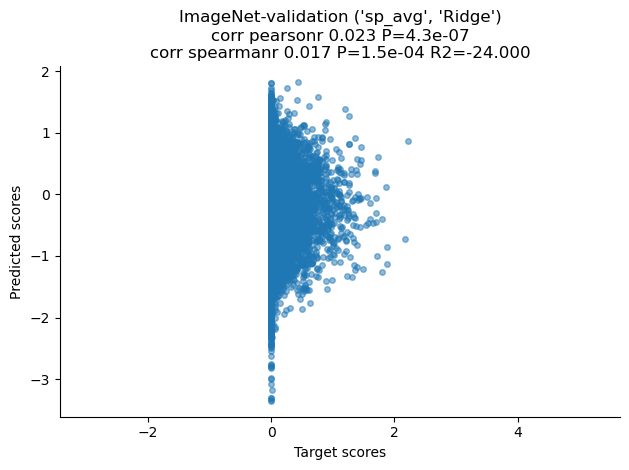

('sp_rf', 'Ridge') spearman: 0.074 P=8.1e-62 pearson: 0.073 P=1.3e-59 R2=-4.440


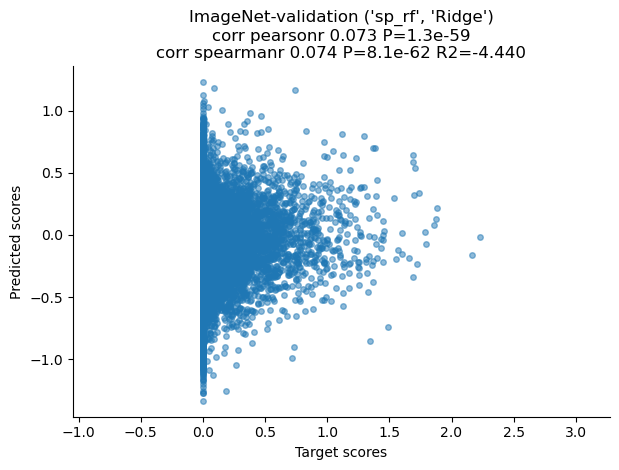

('sp_rf', 'KernelRBF') spearman: 0.075 P=7.6e-64 pearson: 0.072 P=1.6e-58 R2=-5.431


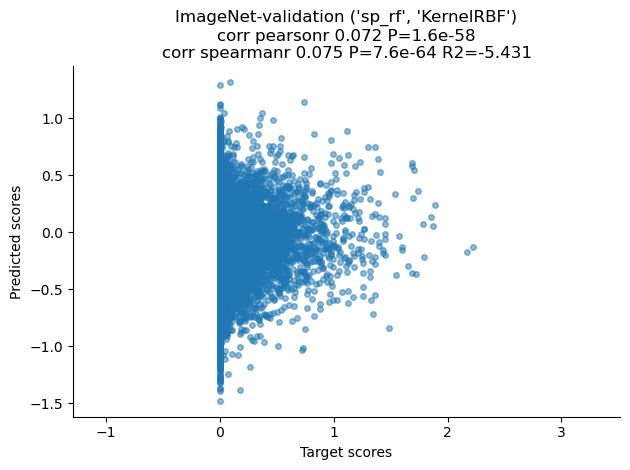

spearman   pearson  ...              dataset n_sample
pca    Ridge      0.053936  0.045486  ...  ImageNet-validation    50000
srp    Ridge      0.045762  0.041442  ...  ImageNet-validation    50000
sp_avg Ridge      0.016976  0.022604  ...  ImageNet-validation    50000
sp_rf  Ridge      0.074095  0.072727  ...  ImageNet-validation    50000
       KernelRBF  0.075335  0.072047  ...  ImageNet-validation    50000

[5 rows x 7 columns]

In [33]:
compare_activation_prediction(target_scores_natval, pred_scores_natval, "ImageNet-validation")

In [ ]:
np.corrcoef(target_scores_natval, pred_scores_natval['srp', "Ridge"])

In [ ]:
msk = target_scores_natval > 0.1
pearsonr(target_scores_natval[msk], pred_scores_natval['srp', "Ridge"][msk])

In [ ]:
#%%

np.corrcoef(target_scores_natval, pred_scores_natval['sp_avg', "Ridge"])

In [ ]:
#%%

sortidx = np.argsort(target_scores_natval)
print(target_scores_natval[sortidx[-10:]])
imgs = [denormalizer(dataset[i][0]) for i in sortidx[-10:]]
show_imgrid(imgs, nrow=5)

In [ ]:
#%%

plt.hist(target_scores_natval, bins=100,alpha=0.4)
plt.hist(pred_scores_natval["pca", "Ridge"], bins=100, alpha=0.2)
plt.hist(pred_scores_natval["srp", "Ridge"], bins=100, alpha=0.2)
plt.legend(["Target scores", "PCA", "SRP"])
plt.xlim([-1, 2])
plt.ylim([0, 200])
plt.show()

In [34]:
#%%

""" Predicting GAN images. """
target_scores_gan = []
pred_scores_gan = defaultdict(list)
for i in tqdm(range(200)):
    imgs = G.visualize(2 * torch.randn(40, 4096).cuda())
    with torch.no_grad():
        score_batch = scorer.score(imgs)
    target_scores_gan.append(score_batch)

    with torch.no_grad():
        featnet(resizer(normalizer(imgs)))
        feattsr = featFetcher[regresslayer]
        feattsr = feattsr.cpu().numpy()
        featmat = feattsr.reshape(feattsr.shape[0], -1)

    featmat_pca = pca.transform(featmat)
    pred_score_pca = fit_models['pca', "Ridge"].predict(featmat_pca)
    pred_scores_gan['pca', "Ridge"].append(pred_score_pca)

    featmat_srp = srp.transform(featmat)
    pred_score_srp = fit_models['srp', "Ridge"].predict(featmat_srp)
    pred_scores_gan['srp', "Ridge"].append(pred_score_srp)
    pred_score_srp = fit_models['srp', "KernelRBF"].predict(featmat_srp)
    pred_scores_gan['srp', "KernelRBF"].append(pred_score_srp)

    featmat_avg = feattsr.mean(axis=(2, 3))
    pred_score_avg = fit_models['sp_avg', "Ridge"].predict(featmat_avg)
    pred_scores_gan['sp_avg', "Ridge"].append(pred_score_avg)

    featmat_rf = feattsr[:, :, 6, 6]
    pred_score_rf = fit_models['sp_rf', "Ridge"].predict(featmat_rf)
    pred_scores_gan['sp_rf', "Ridge"].append(pred_score_rf)

for k in pred_scores_gan:
    pred_scores_gan[k] = np.concatenate(pred_scores_gan[k], axis=0)

target_scores_gan = np.concatenate(target_scores_gan, axis=0)

  0%|          | 0/200 [00:00<?, ?it/s]

('pca', 'Ridge') spearman: 0.113 P=4.2e-24 pearson: 0.107 P=5.4e-22 R2=-1.230


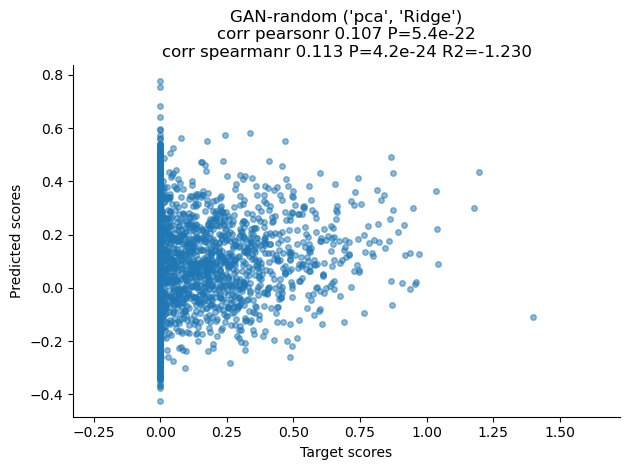

('srp', 'Ridge') spearman: 0.117 P=8.2e-26 pearson: 0.123 P=3.8e-28 R2=-1.640


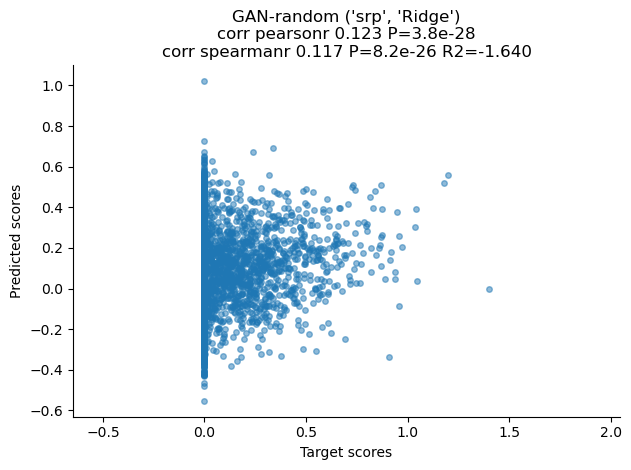

('srp', 'KernelRBF') spearman: 0.115 P=7.1e-25 pearson: 0.118 P=3.0e-26 R2=-1.295


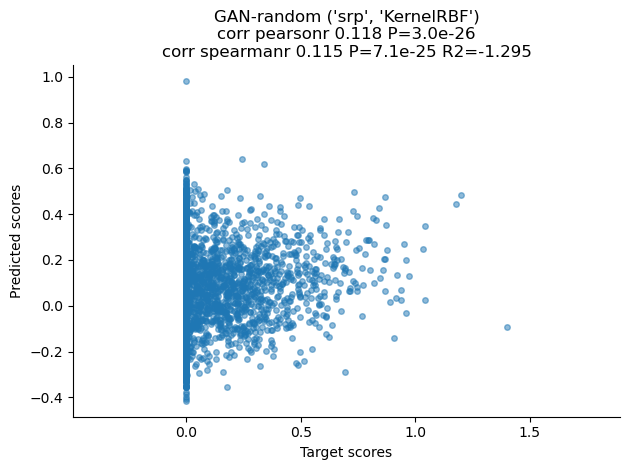

('sp_avg', 'Ridge') spearman: 0.047 P=2.5e-05 pearson: 0.048 P=1.9e-05 R2=-4.885


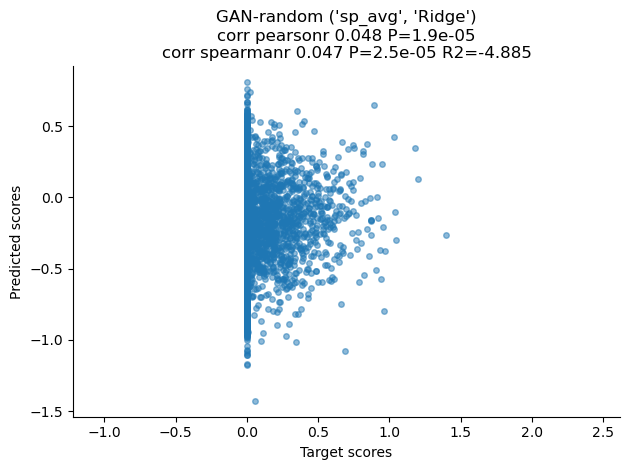

('sp_rf', 'Ridge') spearman: 0.167 P=2.6e-51 pearson: 0.160 P=8.9e-47 R2=-2.857


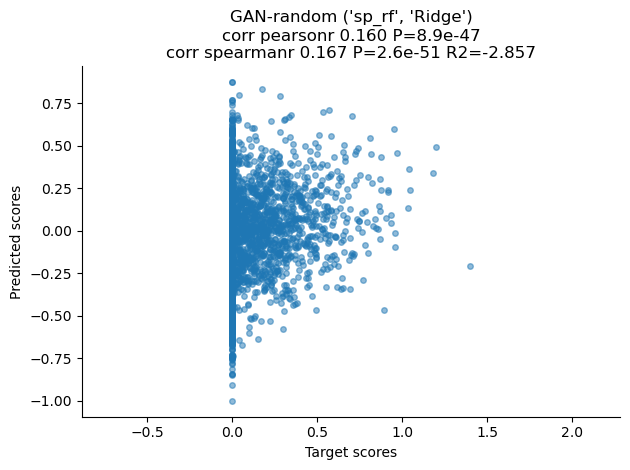

spearman   pearson  ...     dataset n_sample
pca    Ridge       0.11288  0.107479  ...  GAN-random     8000
srp    Ridge      0.117061  0.122549  ...  GAN-random     8000
       KernelRBF  0.114782  0.118105  ...  GAN-random     8000
sp_avg Ridge       0.04712  0.047727  ...  GAN-random     8000
sp_rf  Ridge      0.167319  0.159576  ...  GAN-random     8000

[5 rows x 7 columns]

In [35]:
compare_activation_prediction(target_scores_gan, pred_scores_gan, "GAN-random")

In [36]:
model_list = [('pca', "Ridge"), ('srp', "Ridge"), ('sp_avg', "Ridge"),
              ('sp_rf', "Ridge"), ('sp_rf', "KernelRBF")]
target_scores_gan = []
pred_scores_gan = defaultdict(list)
for i in tqdm(range(200)):
    imgs = G.visualize(2 * torch.randn(40, 4096).cuda())
    with torch.no_grad():
        score_batch = scorer.score(imgs)
    target_scores_gan.append(score_batch)

    with torch.no_grad():
        featnet(resizer(normalizer(imgs)))
        feattsr = featFetcher[regresslayer]
        feattsr = feattsr.cpu().numpy()
        # featmat = feattsr.reshape(feattsr.shape[0], -1)

    for k in model_list:
        featmat_tfm = Xfeat_transformer[k[0]](feattsr)
        pred_score = fit_models[k].predict(featmat_tfm)
        pred_scores_gan[k].append(pred_score)

for k in pred_scores_gan:
    pred_scores_gan[k] = np.concatenate(pred_scores_gan[k], axis=0)

target_scores_gan = np.concatenate(target_scores_gan, axis=0)

  0%|          | 0/200 [00:00<?, ?it/s]

('pca', 'Ridge') spearman: 0.119 P=1.1e-26 pearson: 0.106 P=1.3e-21 R2=-1.199


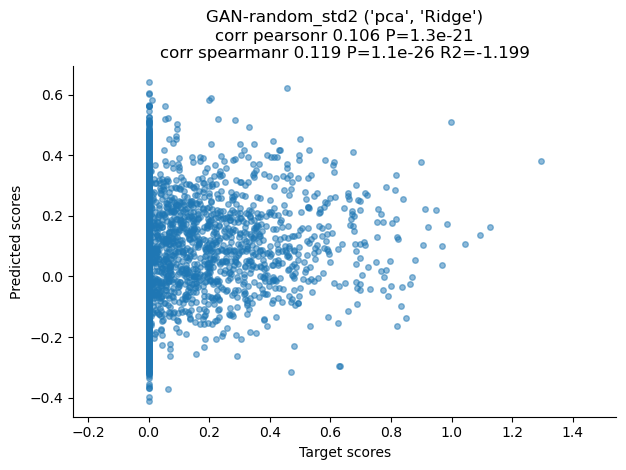

('srp', 'Ridge') spearman: 0.121 P=1.9e-27 pearson: 0.106 P=3.0e-21 R2=-1.661


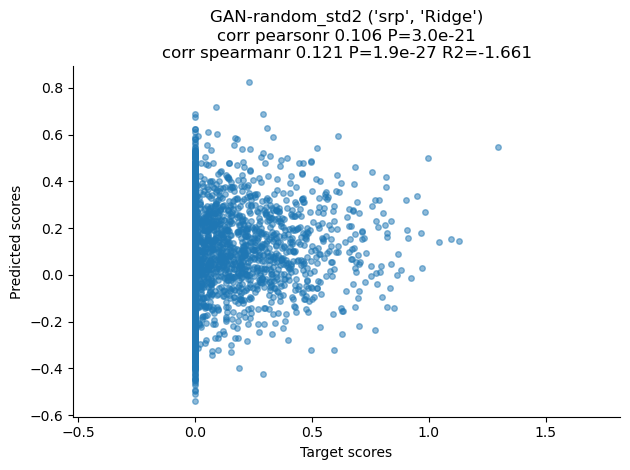

('sp_avg', 'Ridge') spearman: 0.055 P=8.1e-07 pearson: 0.051 P=6.1e-06 R2=-4.880


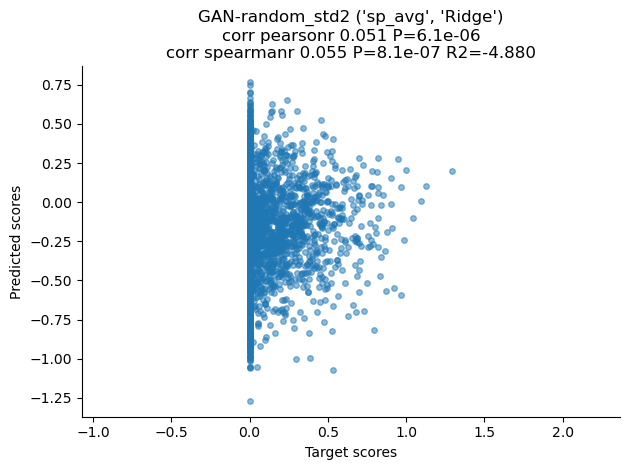

('sp_rf', 'Ridge') spearman: 0.178 P=5.1e-58 pearson: 0.174 P=1.4e-55 R2=-2.722


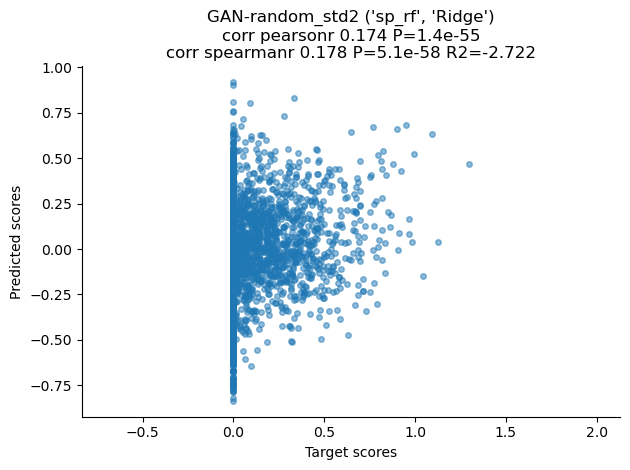

('sp_rf', 'KernelRBF') spearman: 0.179 P=8.5e-59 pearson: 0.175 P=3.6e-56 R2=-3.224


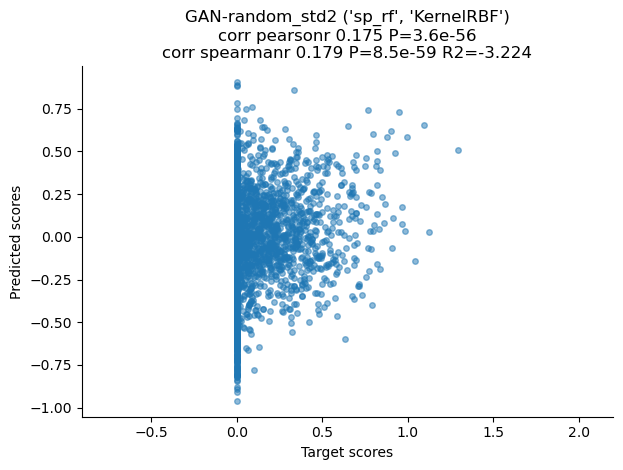

spearman   pearson  ...          dataset n_sample
pca    Ridge      0.119137  0.106474  ...  GAN-random_std2     8000
srp    Ridge      0.120933   0.10553  ...  GAN-random_std2     8000
sp_avg Ridge      0.055107  0.050559  ...  GAN-random_std2     8000
sp_rf  Ridge      0.178112   0.17428  ...  GAN-random_std2     8000
       KernelRBF  0.179326  0.175216  ...  GAN-random_std2     8000

[5 rows x 7 columns]

In [37]:
compare_activation_prediction(target_scores_gan, pred_scores_gan, "GAN-random_std2")

### Re-evolution experiments, cross evolution generalization

In [38]:
#%% Another evolution experiment

model_list = [('pca', "Ridge"), ('srp', "Ridge"), ('sp_avg', "Ridge"),
              ('sp_rf', "Ridge"), ('sp_rf', "KernelRBF")]
target_scores_reevol = []
pred_scores_reevol = defaultdict(list)

optimizer = CholeskyCMAES(4096, population_size=None, init_sigma=3.0)
z_arr = np.zeros((1, 4096))  # optimizer.init_x
for i in tqdm(range(100)):
    imgs = G.visualize(torch.tensor(z_arr).float().cuda())
    with torch.no_grad():
        score_batch = scorer.score(imgs)
    target_scores_reevol.append(score_batch)
    z_arr = optimizer.step_simple(score_batch, z_arr)

    with torch.no_grad():
        featnet(resizer(normalizer(imgs)))
        feattsr = featFetcher[regresslayer]
        feattsr = feattsr.cpu().numpy()

    for k in model_list:
        featmat_tfm = Xfeat_transformer[k[0]](feattsr)
        pred_score = fit_models[k].predict(featmat_tfm)
        pred_scores_reevol[k].append(pred_score)

for k in pred_scores_gan:
    pred_scores_reevol[k] = np.concatenate(pred_scores_reevol[k], axis=0)

target_scores_reevol = np.concatenate(target_scores_reevol, axis=0)

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


  0%|          | 0/100 [00:00<?, ?it/s]

sigma: 2.90
sigma: 2.83
sigma: 2.76
sigma: 2.71
sigma: 2.66
sigma: 2.62
sigma: 2.58
sigma: 2.55
sigma: 2.52
sigma: 2.50
sigma: 2.47
A, Ainv update! Time cost: 0.23 s
sigma: 2.45
sigma: 2.43
sigma: 2.42
sigma: 2.41
sigma: 2.39
sigma: 2.38
sigma: 2.37
sigma: 2.37
sigma: 2.36
sigma: 2.35
sigma: 2.35
A, Ainv update! Time cost: 0.23 s
sigma: 2.34
sigma: 2.34
sigma: 2.34
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
A, Ainv update! Time cost: 0.22 s
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.33
sigma: 2.34
sigma: 2.34
sigma: 2.34
A, Ainv update! Time cost: 0.23 s
sigma: 2.34
sigma: 2.35
sigma: 2.35
sigma: 2.35
sigma: 2.36
sigma: 2.36
sigma: 2.36
sigma: 2.37
sigma: 2.37
sigma: 2.37
sigma: 2.37
A, Ainv update! Time cost: 0.23 s
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
sigma: 2.38
A, Ainv update! Time cost: 0.22 s
sigm

('pca', 'Ridge') spearman: 0.277 P=7.0e-71 pearson: 0.406 P=4.1e-157 R2=0.109


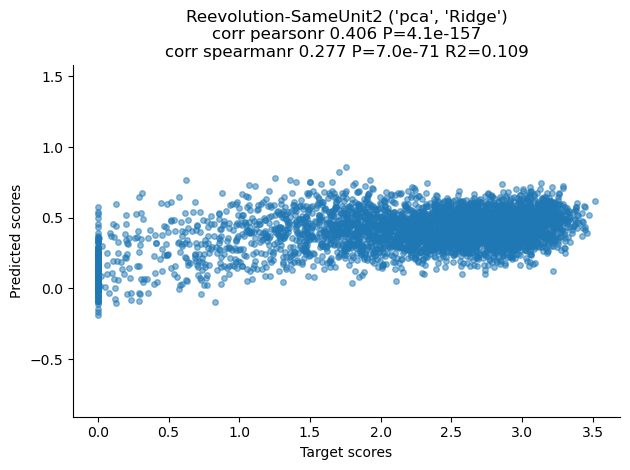

('srp', 'Ridge') spearman: -0.095 P=2.2e-09 pearson: 0.071 P=6.9e-06 R2=-0.018


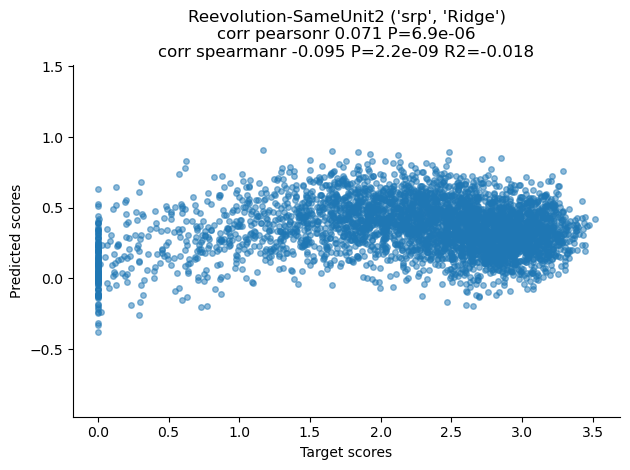

('sp_avg', 'Ridge') spearman: 0.333 P=2.4e-103 pearson: 0.498 P=1.3e-247 R2=0.219


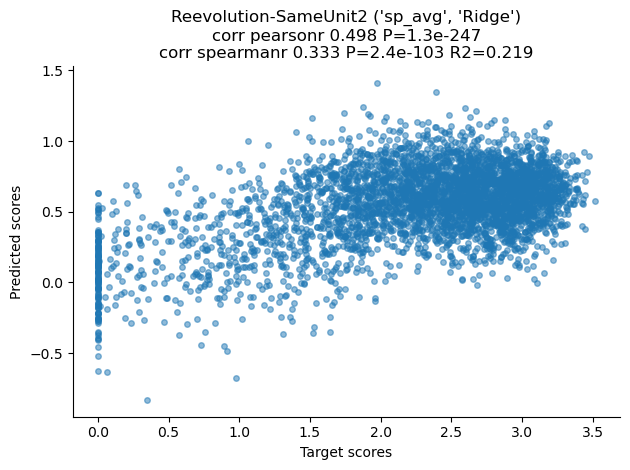

('sp_rf', 'Ridge') spearman: 0.297 P=2.8e-81 pearson: 0.576 P=0.0e+00 R2=0.318


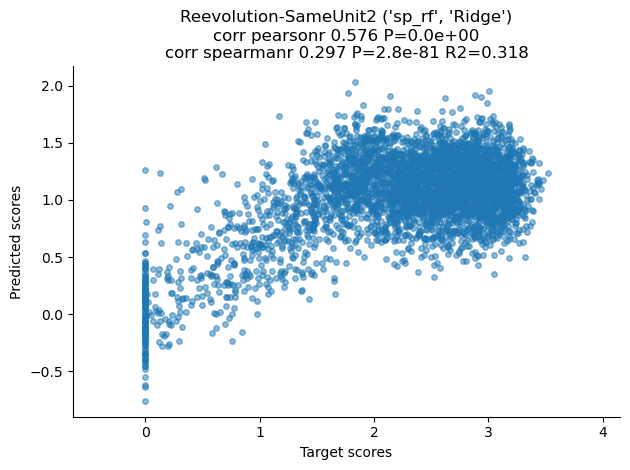

('sp_rf', 'KernelRBF') spearman: 0.283 P=6.1e-74 pearson: 0.542 P=1.0e-301 R2=0.286


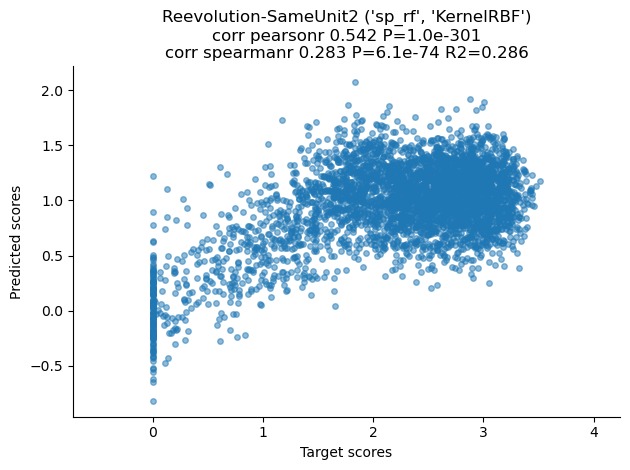

spearman   pearson  ...                dataset n_sample
pca    Ridge      0.277358  0.406033  ...  Reevolution-SameUnit2     3961
srp    Ridge     -0.094913    0.0714  ...  Reevolution-SameUnit2     3961
sp_avg Ridge      0.333258  0.498238  ...  Reevolution-SameUnit2     3961
sp_rf  Ridge      0.296635  0.575992  ...  Reevolution-SameUnit2     3961
       KernelRBF  0.283192  0.542277  ...  Reevolution-SameUnit2     3961

[5 rows x 7 columns]

In [39]:
compare_activation_prediction(target_scores_reevol, pred_scores_reevol,
                              "Reevolution-SameUnit2")

In [ ]:
show_imgrid(imgs, )

('pca', 'Ridge') spearman: 0.942 P=0.0e+00 pearson: 0.959 P=0.0e+00 R2=0.920


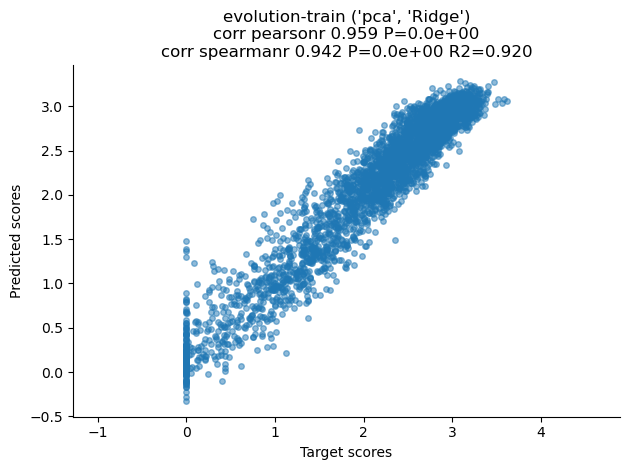

('srp', 'Ridge') spearman: 0.971 P=0.0e+00 pearson: 0.982 P=0.0e+00 R2=0.963


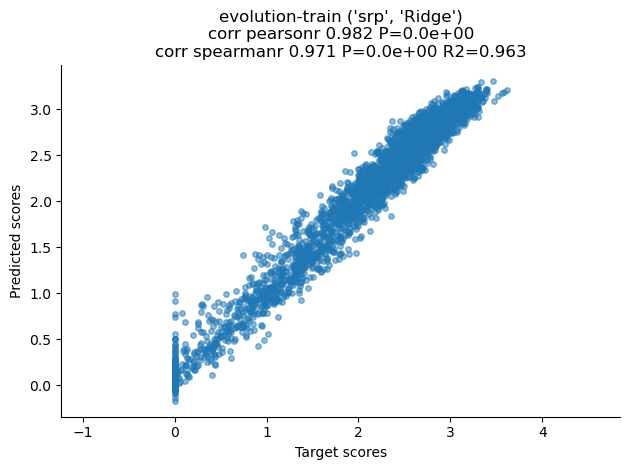

('sp_avg', 'Ridge') spearman: 0.937 P=0.0e+00 pearson: 0.955 P=0.0e+00 R2=0.912


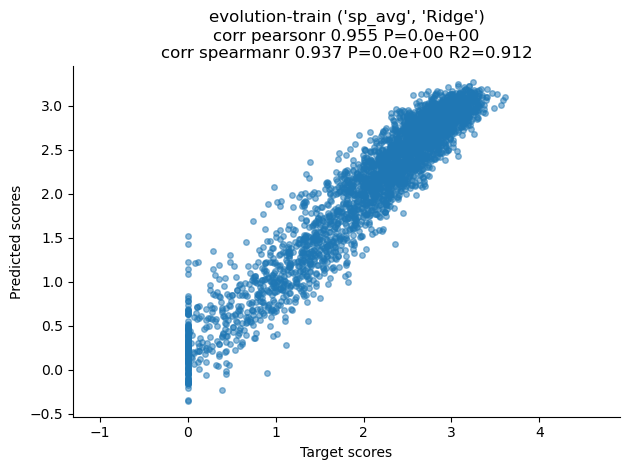

('sp_rf', 'Ridge') spearman: 0.950 P=0.0e+00 pearson: 0.967 P=0.0e+00 R2=0.935


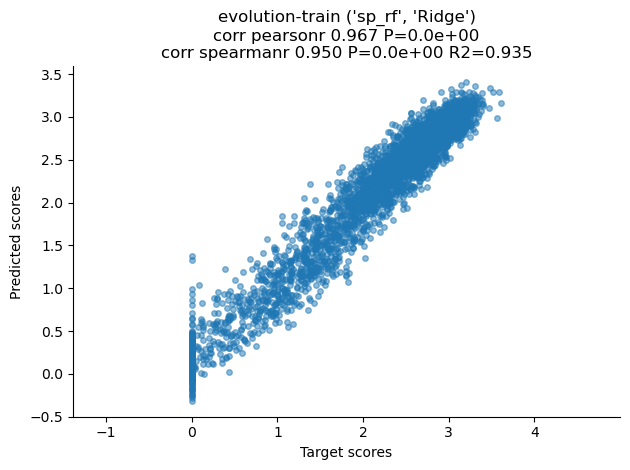

('sp_rf', 'KernelRBF') spearman: 0.956 P=0.0e+00 pearson: 0.972 P=0.0e+00 R2=0.944


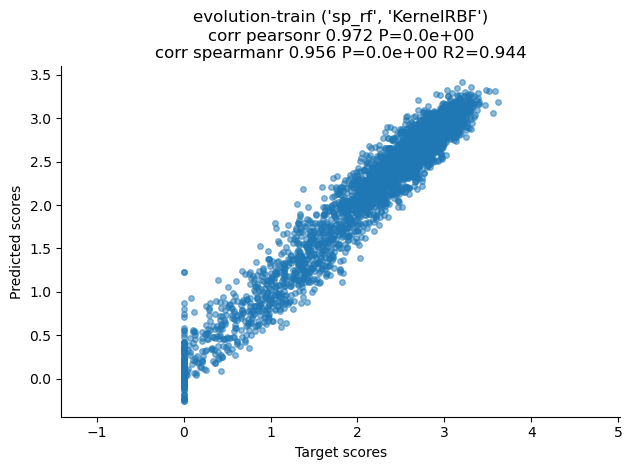

('pca', 'Ridge') spearman: 0.929 P=0.0e+00 pearson: 0.947 P=0.0e+00 R2=0.897


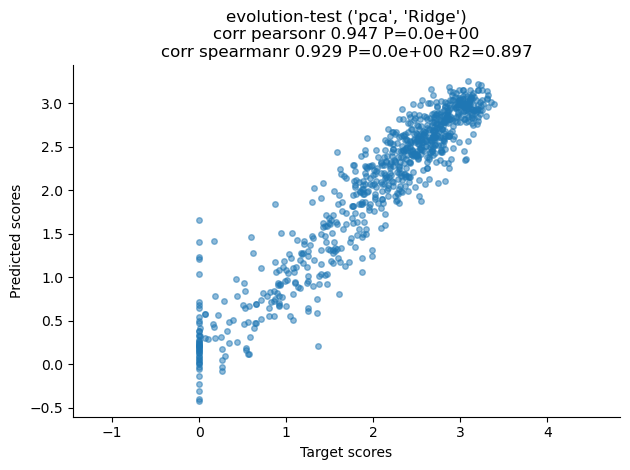

('srp', 'Ridge') spearman: 0.936 P=0.0e+00 pearson: 0.949 P=0.0e+00 R2=0.901


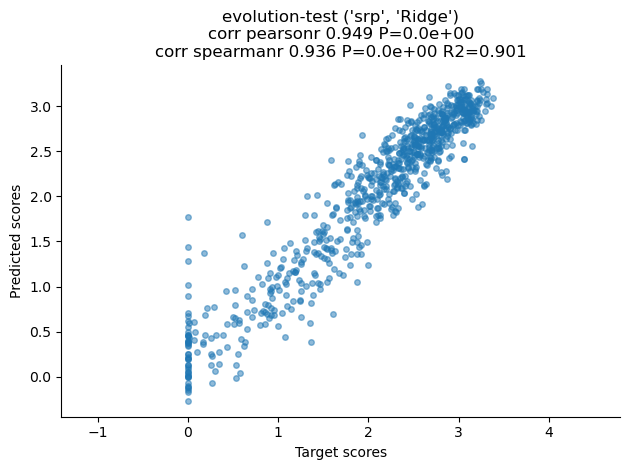

('sp_avg', 'Ridge') spearman: 0.923 P=0.0e+00 pearson: 0.938 P=0.0e+00 R2=0.879


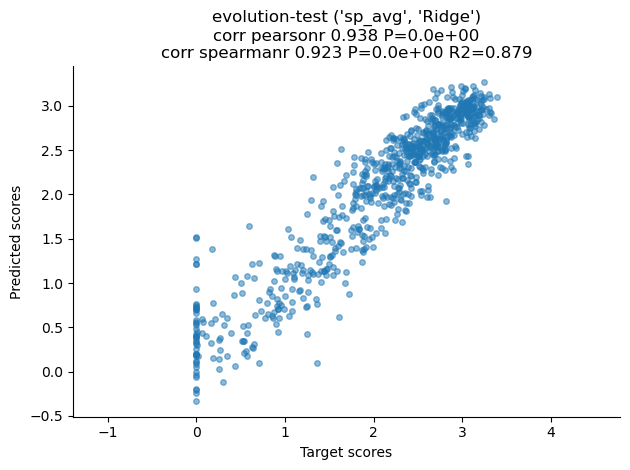

('sp_rf', 'Ridge') spearman: 0.951 P=0.0e+00 pearson: 0.959 P=0.0e+00 R2=0.920


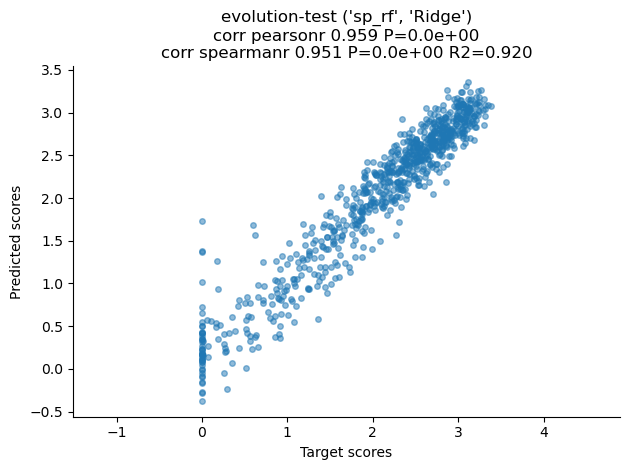

('sp_rf', 'KernelRBF') spearman: 0.951 P=0.0e+00 pearson: 0.960 P=0.0e+00 R2=0.921


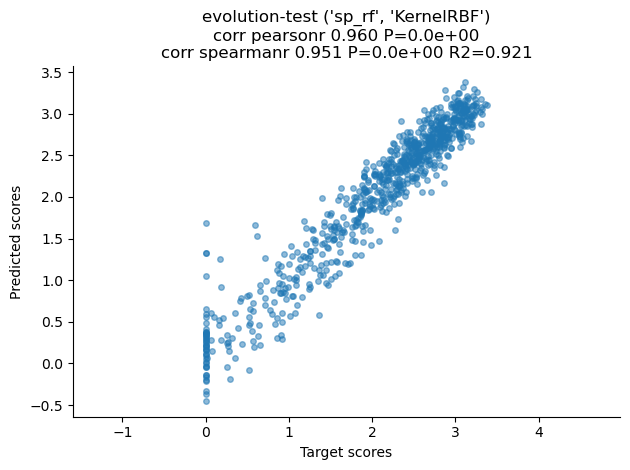

('pca', 'Ridge') spearman: 0.119 P=1.1e-26 pearson: 0.106 P=1.3e-21 R2=-1.199


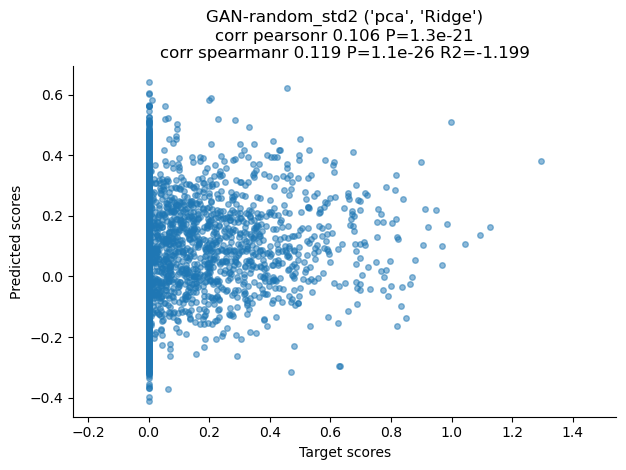

('srp', 'Ridge') spearman: 0.121 P=1.9e-27 pearson: 0.106 P=3.0e-21 R2=-1.661


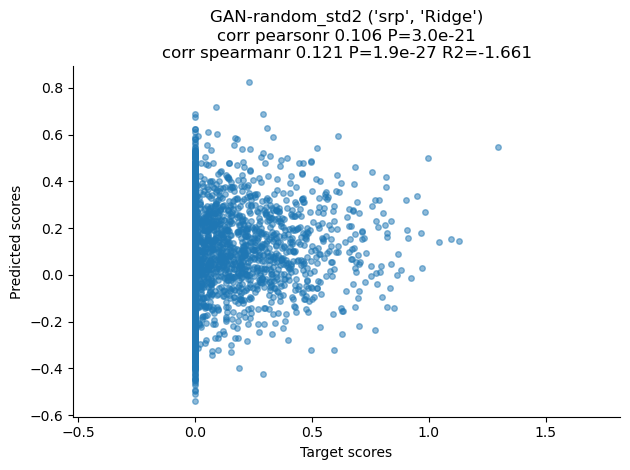

('sp_avg', 'Ridge') spearman: 0.055 P=8.1e-07 pearson: 0.051 P=6.1e-06 R2=-4.880


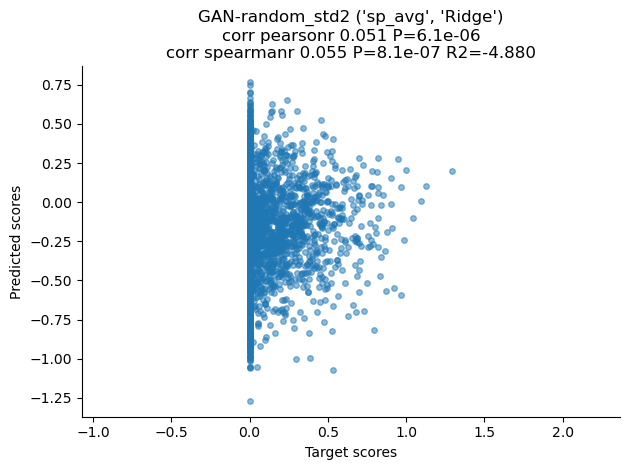

('sp_rf', 'Ridge') spearman: 0.178 P=5.1e-58 pearson: 0.174 P=1.4e-55 R2=-2.722


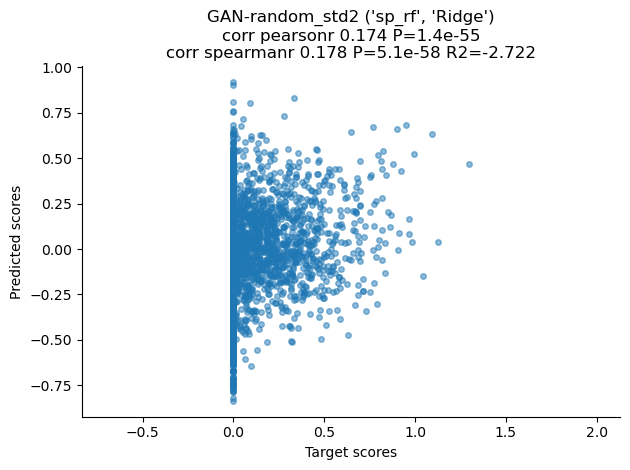

('sp_rf', 'KernelRBF') spearman: 0.179 P=8.5e-59 pearson: 0.175 P=3.6e-56 R2=-3.224


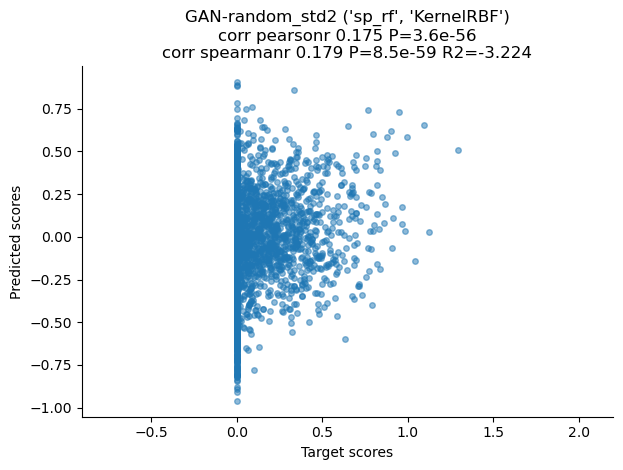

('pca', 'Ridge') spearman: 0.277 P=7.0e-71 pearson: 0.406 P=4.1e-157 R2=0.109


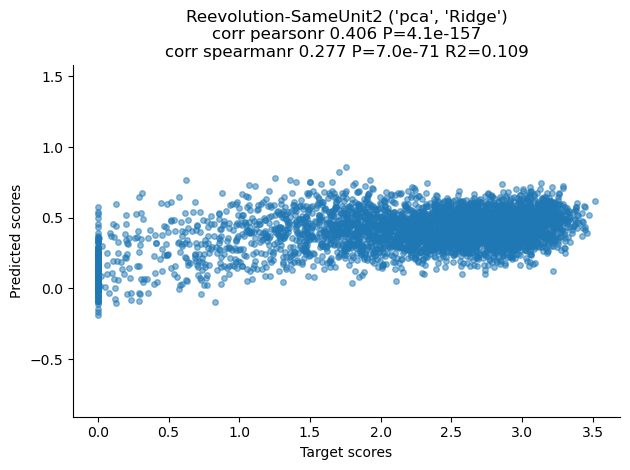

('srp', 'Ridge') spearman: -0.095 P=2.2e-09 pearson: 0.071 P=6.9e-06 R2=-0.018


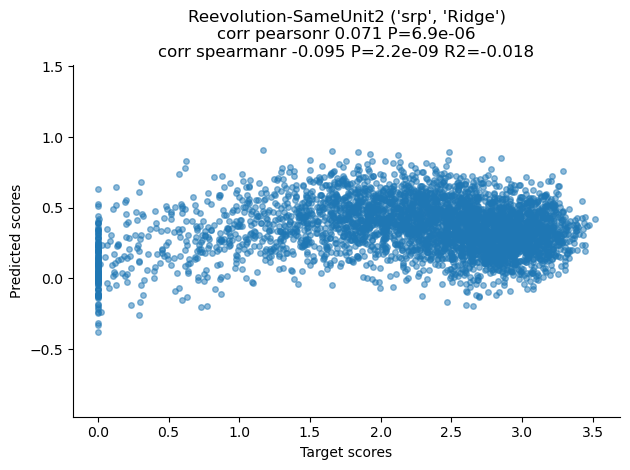

('sp_avg', 'Ridge') spearman: 0.333 P=2.4e-103 pearson: 0.498 P=1.3e-247 R2=0.219


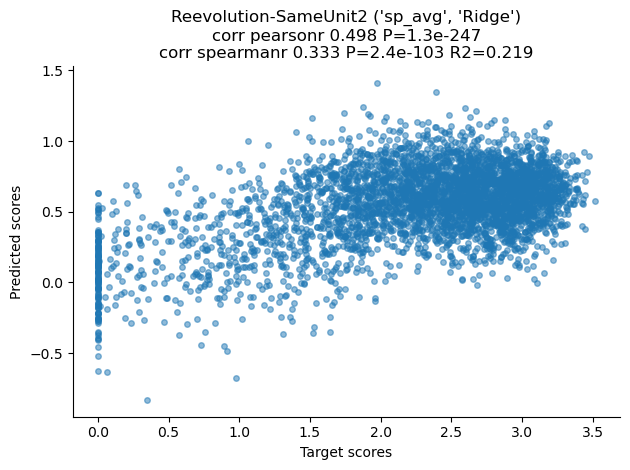

('sp_rf', 'Ridge') spearman: 0.297 P=2.8e-81 pearson: 0.576 P=0.0e+00 R2=0.318


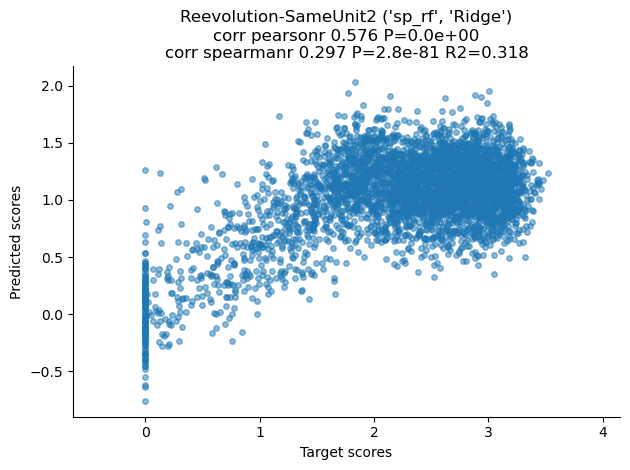

('sp_rf', 'KernelRBF') spearman: 0.283 P=6.1e-74 pearson: 0.542 P=1.0e-301 R2=0.286


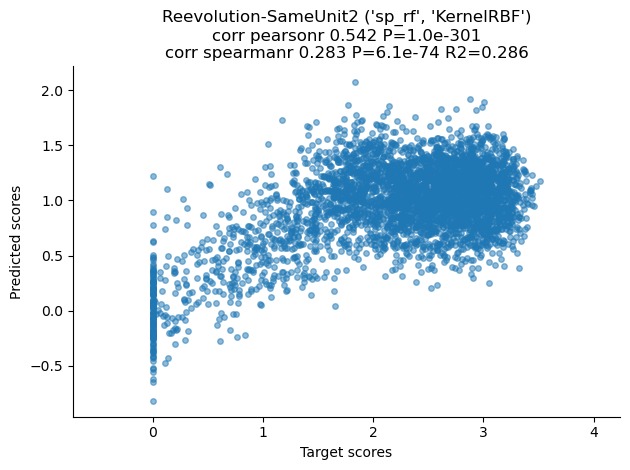

('pca', 'Ridge') spearman: 0.054 P=1.5e-33 pearson: 0.045 P=2.5e-24 R2=-1.426


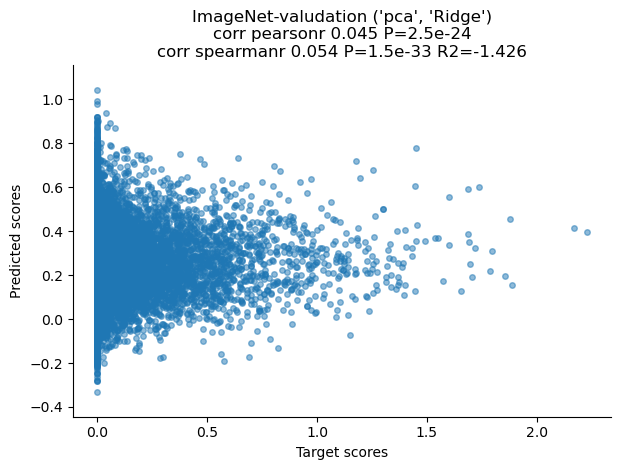

('srp', 'Ridge') spearman: 0.046 P=1.3e-24 pearson: 0.041 P=1.9e-20 R2=-2.894


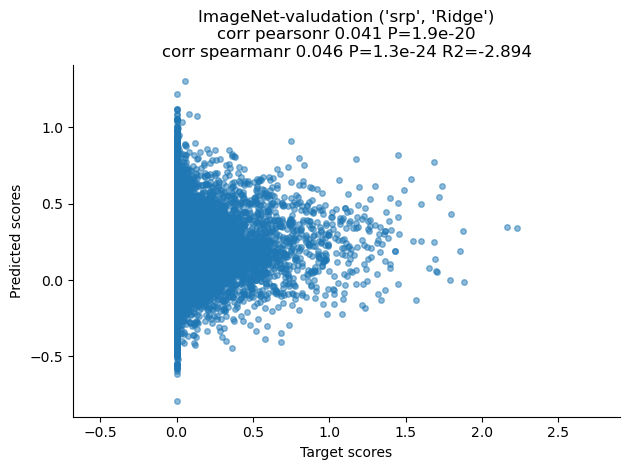

('sp_avg', 'Ridge') spearman: 0.017 P=1.5e-04 pearson: 0.023 P=4.3e-07 R2=-24.000


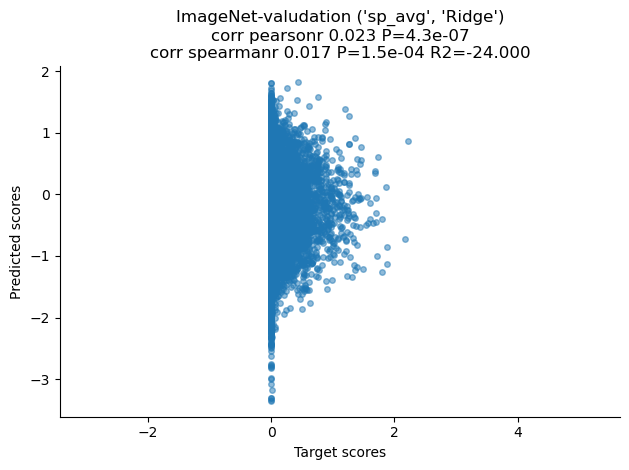

('sp_rf', 'Ridge') spearman: 0.074 P=8.1e-62 pearson: 0.073 P=1.3e-59 R2=-4.440


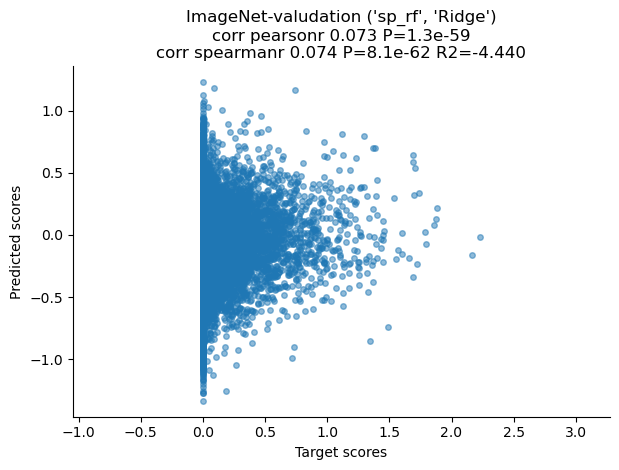

('sp_rf', 'KernelRBF') spearman: 0.075 P=7.6e-64 pearson: 0.072 P=1.6e-58 R2=-5.431


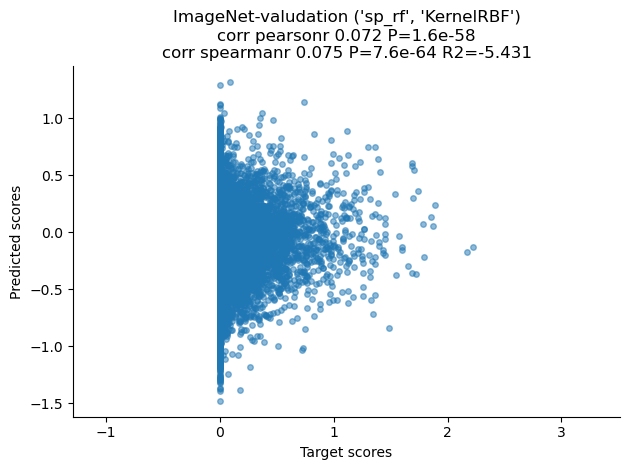

In [43]:
#%% Synopsis
savedir = join(dataroot, "insilico_results")
df_evoltrain = compare_activation_prediction(target_scores_evol_train, pred_scores_evol_train, "evolution-train", savedir=savedir)
df_evoltest = compare_activation_prediction(target_scores_evol_test, pred_scores_evol_test, "evolution-test", savedir=savedir)
df_GANrand = compare_activation_prediction(target_scores_gan, pred_scores_gan, "GAN-random_std2", savedir=savedir)
df_reevol = compare_activation_prediction(target_scores_reevol, pred_scores_reevol, "Reevolution-SameUnit2", savedir=savedir)
df_ImageNet = compare_activation_prediction(target_scores_natval, pred_scores_natval, "ImageNet-valudation", savedir=savedir)
df_synopsis = pd.concat([df_evoltrain, df_evoltest, df_reevol, df_GANrand, df_ImageNet], axis=0)
df_synopsis.to_csv(join(dataroot, "insilico_results", "synopsis.csv"))

In [42]:
!mkdir /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/DNN_neural_regress/insilico_results

In [ ]:
#%%

df_synopsis = df_synopsis.astype({'spearman': 'float64', 'pearson': 'float64',
                    "spearman_pval": 'float64', "pearson_pval": 'float64', "R2": 'float64',
                    "dataset": str, "n_sample": int})
df_synops_col = df_synopsis.reset_index()
df_synops_col.rename(columns={"level_0": "xtype", "level_1": "regressor"}, inplace=True)

In [ ]:
#%% Evaluate the generalization gap

for stat in ["pearson", "spearman", "R2"]:
    df_synops_col.groupby(["xtype", "regressor", "dataset"], sort=False)[stat].mean()\
        .unstack(level=[0,1]).plot(kind="barh",)
    plt.xlabel(stat)
    plt.tight_layout()
    plt.savefig(join(dataroot, "insilico_results", \
                     "model_generalization_synopsis_" + stat + ".png"))
    plt.savefig(join(dataroot, "insilico_results", \
                     "model_generalization_synopsis_" + stat + ".pdf"))
    plt.show()

In [ ]:
#%%

import pickle as pkl
with open(join(dataroot, "insilico_results", "Evol_train_model_generalize.pkl"), "wb") as f:
    pkl.dump({"target_scores_evol_train": target_scores_evol_train, "pred_scores_evol_train": pred_scores_evol_train,
            "target_scores_evol_test": target_scores_evol_test, "pred_scores_evol_test": pred_scores_evol_test,
            "target_scores_gan": target_scores_gan, "pred_scores_gan": pred_scores_gan,
            "target_scores_reevol": target_scores_reevol, "pred_scores_reevol": pred_scores_reevol,
            "target_scores_natval": target_scores_natval, "pred_scores_natval": pred_scores_natval, }
    , f)

In [ ]:
#%%

df_synopsis.loc["sp_rf", "Ridge"].plot(kind="barh", y="pearson", x="dataset", )
plt.tight_layout()
plt.show()

In [ ]:
#%%

df_synopsis.plot(kind="barh", y="pearson", x="dataset", stacked=False,
                 color=["red", "blue", "green", "orange", "black"])
plt.tight_layout()
plt.show()

In [ ]:
#%%

df_synopsis.groupby(level=[0,1]).unstack(level=[0,1]).plot(kind="barh", y="pearson", x="dataset",
                 color=["red", "blue", "green", "orange", "black"])
plt.tight_layout()
plt.show()

In [ ]:
#%%

df_synops_col.groupby(["xtype", "regressor", "dataset"], sort=False)["R2"].mean()\
    .unstack(level=[0,1]).plot(kind="barh",)
plt.xlabel("R squared")
plt.xlim([-0.4, 1])
plt.tight_layout()
plt.show()

In [ ]:
#%%

df_synopsis.groupby(level=[0,1]).groupby("dataset").mean().unstack(level=[0,1]).\
    plot(kind="barh", y="pearson", x="dataset",)

In [ ]:
#%%

df_synopsis.groupby(by="dataset", level=[0,1]).plot(kind="barh", y="pearson", x="dataset", )